<a href="https://colab.research.google.com/github/trodrigue1304/Fraud_detection_algorithm/blob/master/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Chargement des données et paramétrage de l'environnement de travail**

In [2]:
# Chargement des packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import sklearn as skl
import seaborn as sns
from google.colab import drive
from sklearn.impute import KNNImputer

# Connexion à google drive et importation des données
drive.mount('/content/drive')
id_train=pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv')
tr_train=pd.read_csv('/content/drive/My Drive/projet python/train_transaction.csv')
id_test=pd.read_csv('/content/drive/My Drive/projet python/test_identity.csv')
tr_test=pd.read_csv('/content/drive/My Drive/projet python/test_transaction.csv')

## Affichage de toutes les lignes pour les outputs
pd.options.display.max_rows = 4000

Mounted at /content/drive


### **Première exploration des données**

**Visualisation des données**

In [3]:
id_train.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [4]:
tr_train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.0,30.0,318.0,30.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,495.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#verifier que toutes les TransactionID de id_train existe dans tr_train
print("Taille de la base identity : ",id_train.shape)
print("Taille de la base transaction : ",tr_train.shape)
print("Nombre de transactions uniques de la base transaction : ",id_train['TransactionID'].nunique())
print("Nombre de transactions uniques de la base identity : ",tr_train['TransactionID'].nunique())
print("Proportion de transactions avec id information (train): "+"{:.2%}".format(np.sum(tr_train['TransactionID'].isin(id_train['TransactionID'].unique()))/tr_train['TransactionID'].nunique()))
print("Proportion de transactions avec id information (test): "+"{:.2%}".format(np.sum(tr_test['TransactionID'].isin(id_test['TransactionID'].unique()))/tr_test['TransactionID'].nunique()))

Taille de la base identity :  (144233, 41)
Taille de la base transaction :  (590540, 394)
Nombre de transactions uniques de la base transaction :  144233
Nombre de transactions uniques de la base identity :  590540
Proportion de transactions avec id information (train): 24.42%
Proportion de transactions avec id information (test): 28.01%


On remarque qu'il y a des transactions sans informations d'identification. On ne tiendra pas compte de ces données.

**Fusion des bases de données**

In [6]:
train=pd.merge(tr_train,id_train,on="TransactionID",how="right")
test=pd.merge(tr_test,id_test,on="TransactionID",how="right")

**Type des variables**

In [7]:
train.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8          

**Détection des valeurs manquantes**

In [8]:
missing_data=train.isnull().sum().sum()
total_data=np.product(train.shape)
print("Proportion de données manquantes dans la base : "+"{:.2%}".format(missing_data/total_data))

Proportion de données manquantes dans la base : 26.89%


In [9]:
#Fonction pour la visualition de la répartition des données manquantes
def missing_view(data) :
  null_counts = data.isnull().sum()/len(data)
  plt.figure(figsize=(100,20))
  plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
  plt.ylabel('Proportion de données manquantes')
  plt.bar(np.arange(len(null_counts)),null_counts)


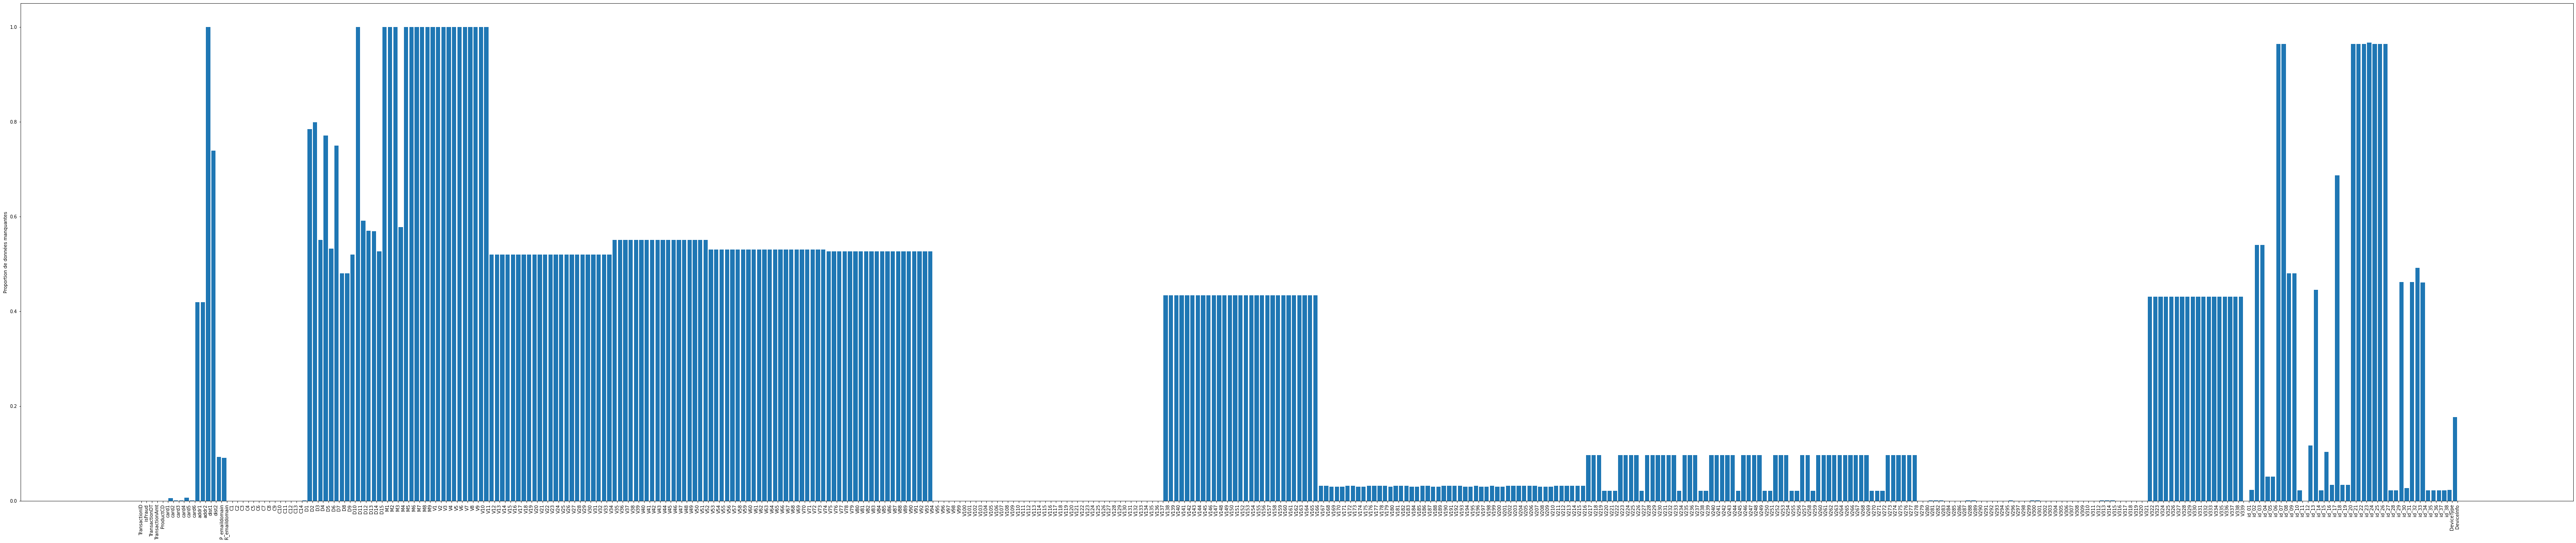

In [10]:
#Visualisation
missing_view(train)

Il faudra donc procéder à un traitement des valeurs manquantes et s'il le faut voir l'impact sur les modèles futurs.

**Analyse de la variable d'intérêt**

In [11]:
#Tableau des effectifs
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab

,TransactionID
isFraud,
0,132915
1,11318


Text(0.5, 1.0, 'Distribution de la variable isFraud')

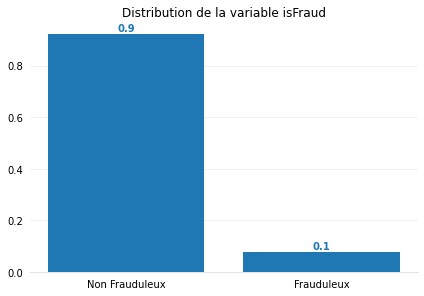

In [12]:
#Visualisation
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

fig.tight_layout()

ax.set_title("Distribution de la variable isFraud")

  On soupçonne un surapprentissage des modèles sur les valeurs non frauduleuses. On recalibre les données de manière à avoir une répartition uniforme.

In [13]:
#Recalibrage
class0=np.where(train['isFraud']==0)[0]
class1=np.where(train['isFraud']==1)[0]
class0_downsample=np.random.choice(class0,size=len(class1),replace=False)
Kept_index=sorted([*class0_downsample,*class1])
train_calibrate=train[train.index.isin(Kept_index)]

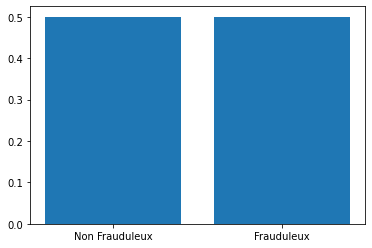

In [14]:
#On s'assure que le tirage a été bien fait
tab = pd.DataFrame(train_calibrate.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

**Visualisation des données manquantes dans la base recalibré**

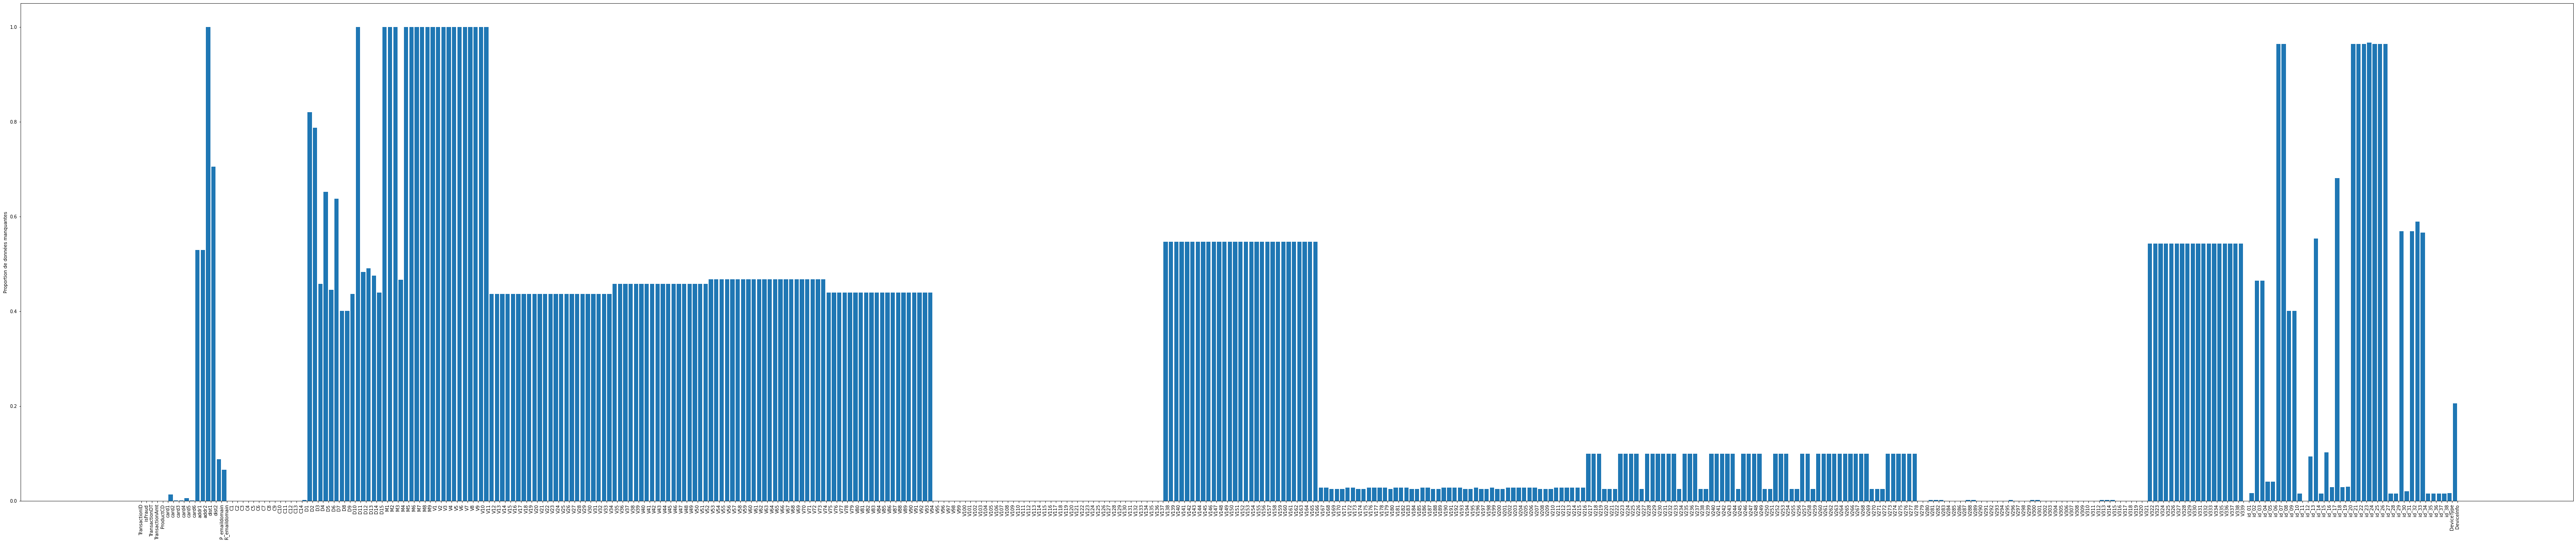

In [15]:
missing_view(train_calibrate)

On remarque que la distribution est quasiment la même avec celle obtenue avant. 
Conclusion : Les données recalibrées sont à l'image des données initiale sur ce plan. On peut donc se restreindre à la nouvelle base pour la suite des travaux.

### **Analyse et traitement des données manquantes**

**Valeurs manquantes suivant la variable d'intérêt**

Text(0.5, 0.98, 'Valeurs manquantes sur les données frauduleuses')

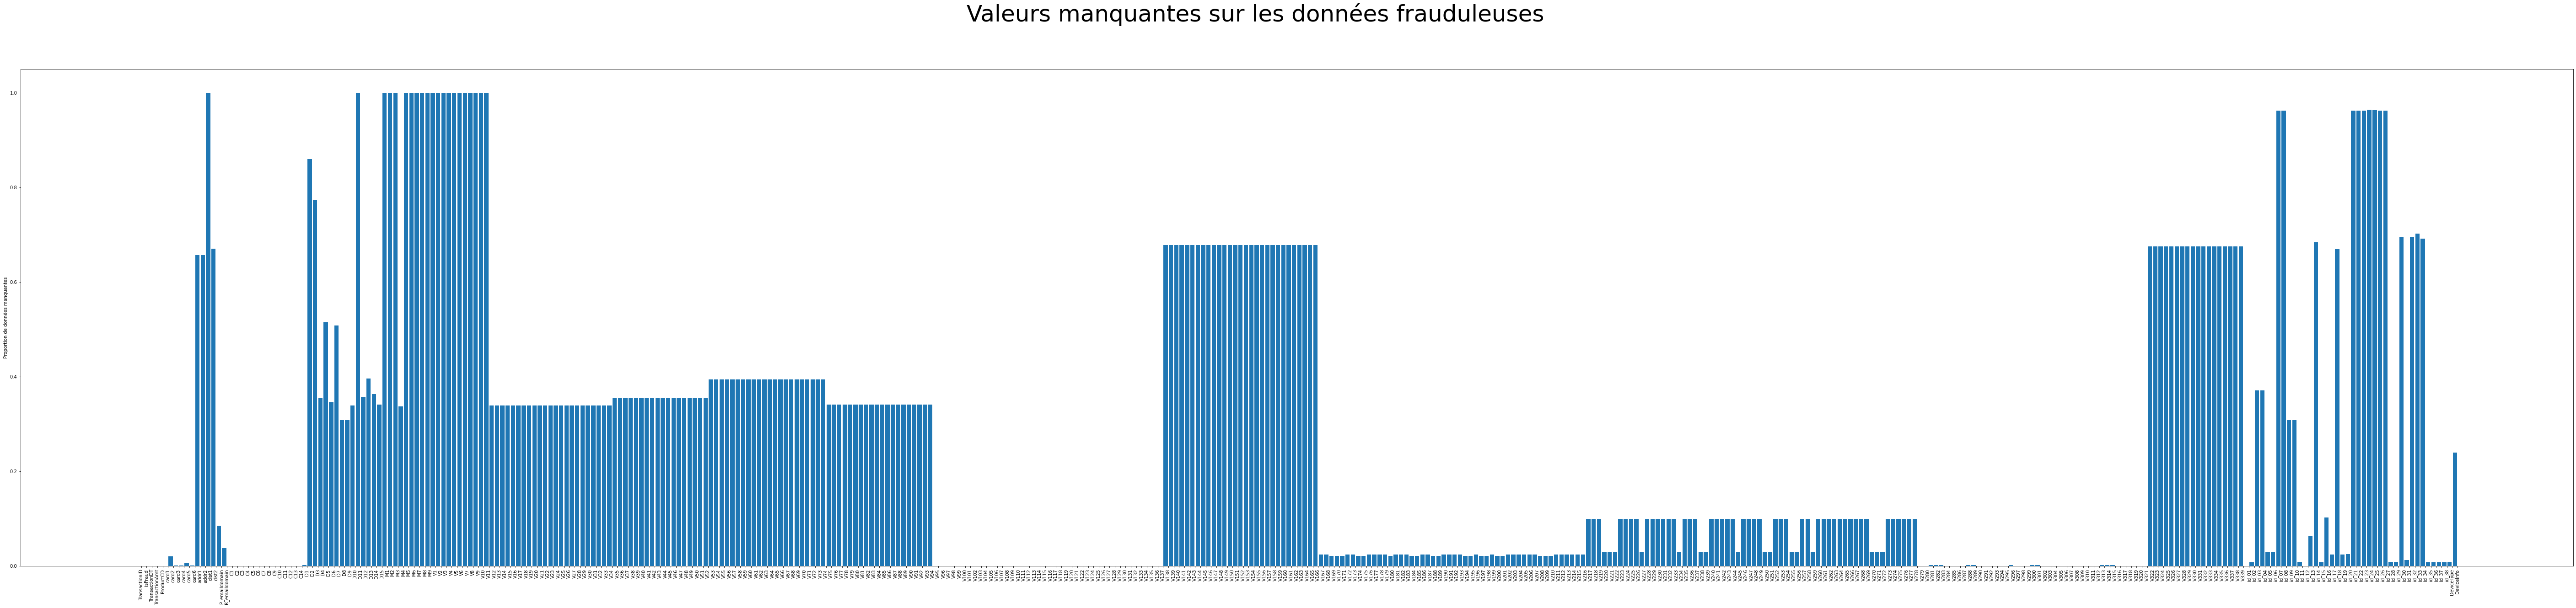

In [16]:
missing_view(train_calibrate[train_calibrate.isFraud == 1])
plt.suptitle("Valeurs manquantes sur les données frauduleuses", fontsize=50)

Text(0.5, 0.98, 'Valeurs manquantes sur les données non frauduleuses')

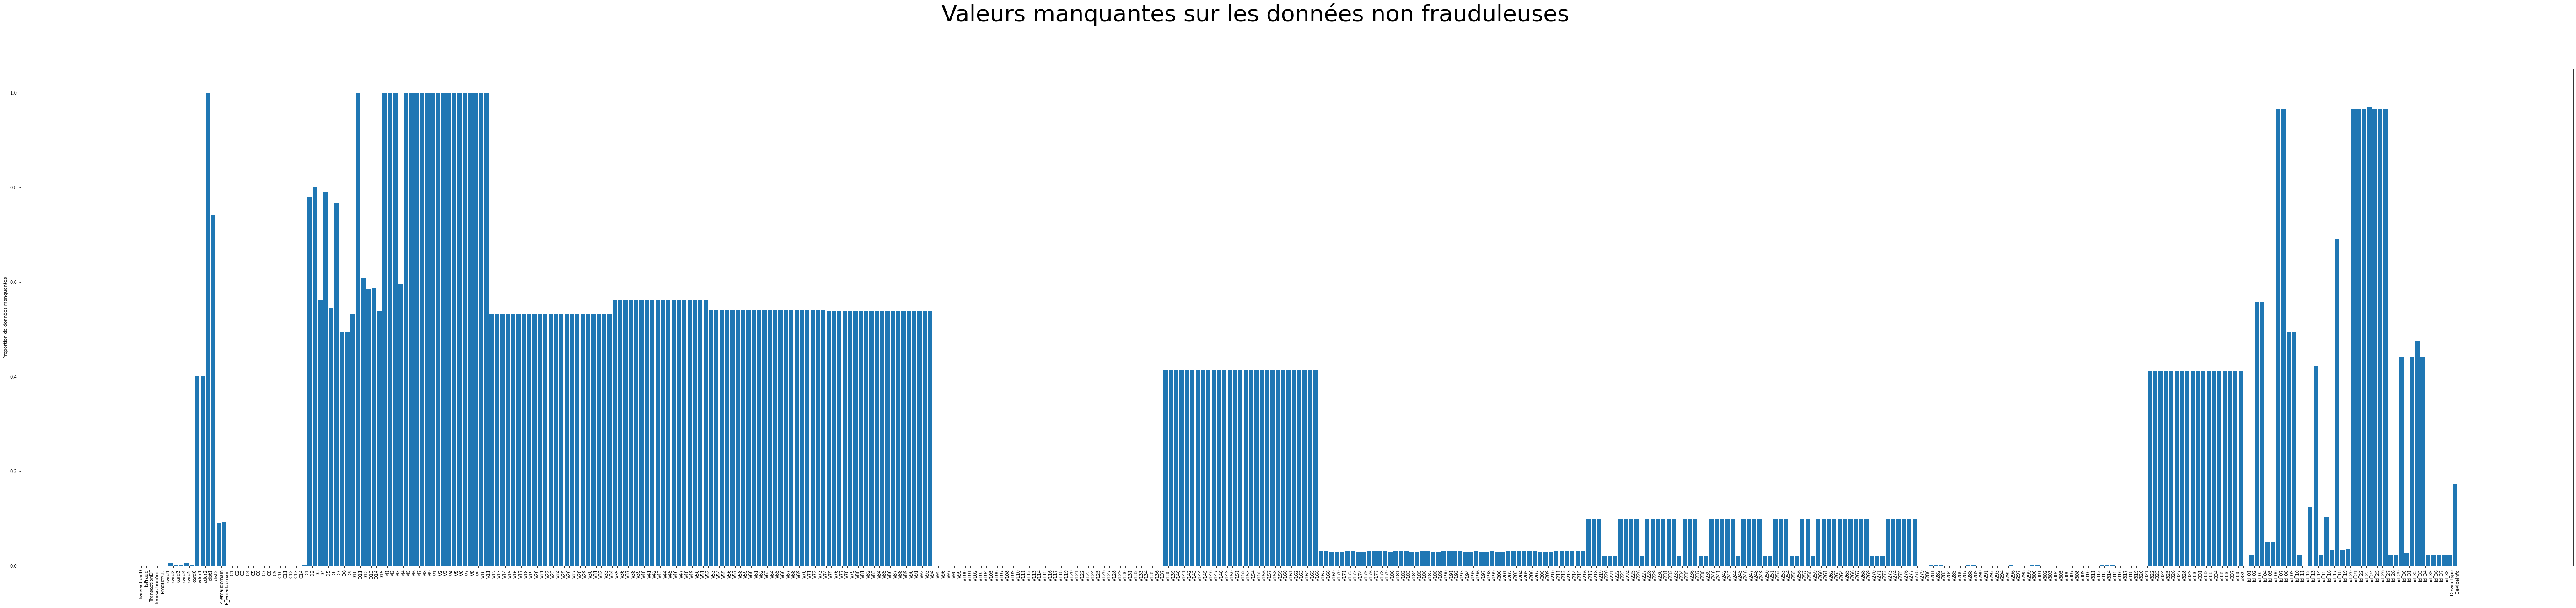

In [17]:
missing_view(train_calibrate[train_calibrate.isFraud == 0])
plt.suptitle("Valeurs manquantes sur les données non frauduleuses", fontsize=50)

De manière générale, on remarque que la représentation est pratiquement la même. On peut dès lors faire une courbe de sensibilité pour voir le nombre de variables par seuil.

**Courbe de sensibilité**

In [18]:
train_column_miss = train_calibrate.isnull().any()
print(f'Nombre de variables avec des données manquantes (apprentissage) : {train_column_miss.sum()} .')

Nombre de variables avec des données manquantes (apprentissage) : 412 .


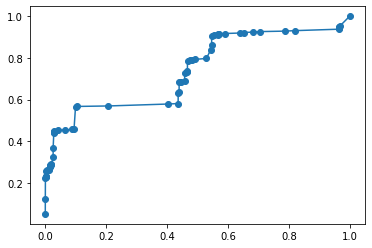

In [19]:
column_miss = train_calibrate.isnull().sum()/train_calibrate.shape[0]
my_series = pd.Series(np.sort(column_miss.values))
sensibility_graph = my_series.value_counts().reset_index().sort_values(by=['index'])
sensibility_graph[0] = np.cumsum(sensibility_graph[0]/sensibility_graph[0].sum())
plt.plot(sensibility_graph['index'], sensibility_graph[0], '-o')

On peut essayer de voir ce qui se passe à partir de 60 % de données manquantes.

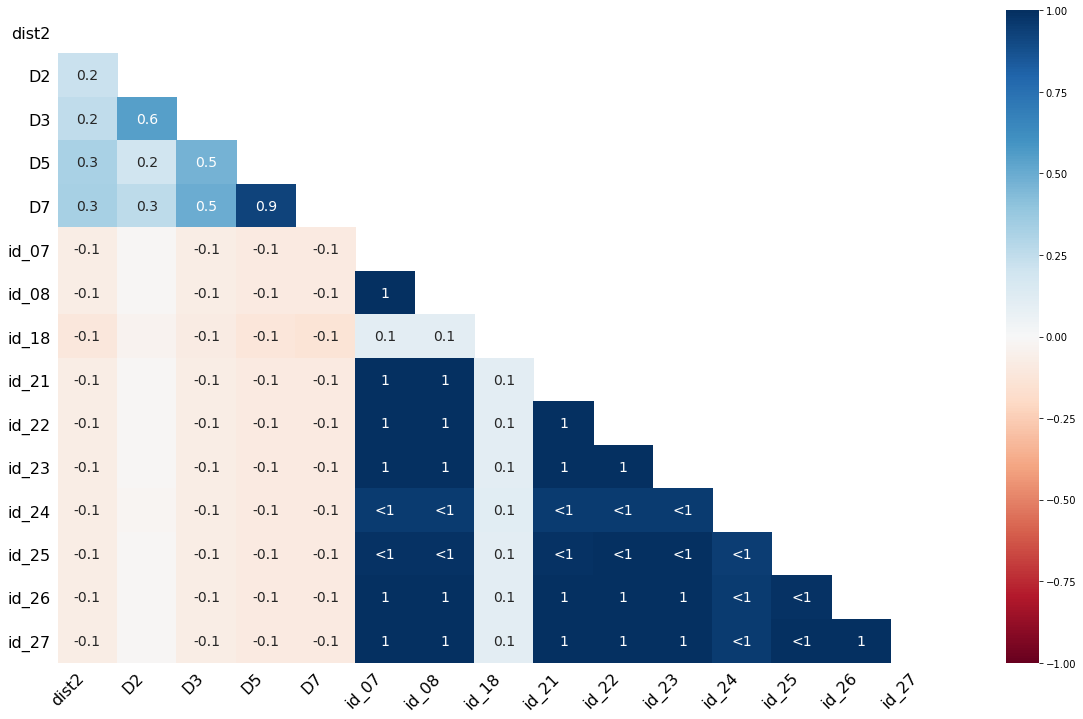

In [20]:
null_counts = train_calibrate.isnull().sum()/len(train_calibrate)
train_data_miss_60 = train_calibrate.filter(items=null_counts[null_counts>=0.6].reset_index()['index'])
msno.heatmap(train_data_miss_60)

On remarque que pour plusieurs des variables, elles prennent conjointement les valeurs manquantes. Couplé au fait que l'apparition des données manquantes est relativement indépendant du caractère frauduleux de la variable, on peut se restreindre aux variables de moins de 60% de valeurs manquantes. De plus, la courbe de sensibilité nous incite à abaisser ce taux à 20% puisqu'il n'y a pas énormément de variables entre 20 et 40%. Une analyse comparative des résultats pourra être ajoutée suivant le seuil choisi.

**Traitement des valeurs manquantes**

In [21]:
###On décide de ne retenir que les variables de moins de 20% de données manquantes et de procéder à une imputation par KNN 
train_work = train_calibrate.filter(items=null_counts[null_counts<0.2].reset_index()['index'])
train_work.shape

(22636, 246)

In [22]:
from sklearn.impute import KNNImputer
train_imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(train_work.select_dtypes(exclude='object'))

In [23]:
train_imputed

array([[2.9870110e+06, 0.0000000e+00, 8.6555000e+04, ..., 2.2500000e+02,
        1.7600000e+02, 5.0700000e+02],
       [2.9870840e+06, 0.0000000e+00, 8.7928000e+04, ..., 2.2500000e+02,
        2.9000000e+02, 4.0100000e+02],
       [2.9871080e+06, 0.0000000e+00, 8.8303000e+04, ..., 1.8960000e+02,
        3.9100000e+02, 3.8980000e+02],
       ...,
       [3.5774780e+06, 0.0000000e+00, 1.5809945e+07, ..., 1.6600000e+02,
        4.1000000e+02, 2.1400000e+02],
       [3.5775060e+06, 0.0000000e+00, 1.5810402e+07, ..., 1.6600000e+02,
        5.2900000e+02, 2.2200000e+02],
       [3.5775260e+06, 1.0000000e+00, 1.5810876e+07, ..., 1.6600000e+02,
        3.5200000e+02, 3.3300000e+02]])

In [24]:
train_imputed = pd.DataFrame(train_imputed)
train_imputed.columns = train_work.select_dtypes(exclude='object').columns
train_imputed = pd.merge(train_imputed,train_work[np.append('TransactionID',train_work.select_dtypes('object').columns.values)],on="TransactionID",how="left")
train_imputed


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987011.0,0.0,86555.0,16.495,4461.0,375.0,185.0,224.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,221832.0,0.0,-6.0,100.000000,52.0,225.0,176.0,507.0,C,mastercard,debit,hotmail.com,hotmail.com,NotFound,New,NotFound,New,NotFound,chrome 62.0,F,F,T,T,desktop
1,2987084.0,0.0,87928.0,125.674,5583.0,103.0,185.0,226.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,436352.0,0.0,0.0,100.000000,52.0,225.0,290.0,401.0,C,visa,credit,anonymous.com,anonymous.com,NotFound,New,NotFound,New,NotFound,chrome 62.0,F,F,T,T,desktop
2,2987108.0,0.0,88303.0,150.000,9515.0,492.0,150.0,226.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-15.0,244292.2,0.4,0.0,100.000000,14.0,189.6,391.0,389.8,H,visa,debit,gmail.com,gmail.com,NotFound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987111.0,0.0,88383.0,18.186,13832.0,375.0,185.0,224.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,252899.0,0.0,0.0,95.080002,52.0,225.0,266.0,325.0,C,mastercard,debit,hotmail.com,hotmail.com,NotFound,New,NotFound,Found,Found,chrome 62.0,F,F,T,T,desktop
4,2987173.0,0.0,89230.0,25.000,4436.0,174.0,150.0,183.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113499.0,0.0,0.0,100.000000,43.2,166.0,215.0,368.0,H,visa,debit,gmail.com,gmail.com,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,T,T,mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22631,3577368.0,1.0,15807677.0,100.000,6758.0,399.0,150.0,146.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,24.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.000000,25.000000,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,214747.0,0.0,0.0,100.000000,27.0,166.0,492.0,225.0,H,american express,credit,hotmail.com,hotmail.com,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
22632,3577397.0,0.0,15808209.0,16.108,5812.0,408.0,185.0,224.0,5.0,11.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,8.0,4.0,4.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,313942.0,0.0,0.0,100.000000,52.0,225.0,266.0,315.0,C,mastercard,debit,gmail.com,gmail.com,NotFound,Found,Found,Found,Found,chrome 66.0,F,F,T,F,desktop
22633,3577478.0,0.0,15809945.0,24.422,6019.0,583.0,150.0,226.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,

**categorical features**

C    12302
R     4482
H     4249
S     1603
Name: ProductCD, dtype: int64


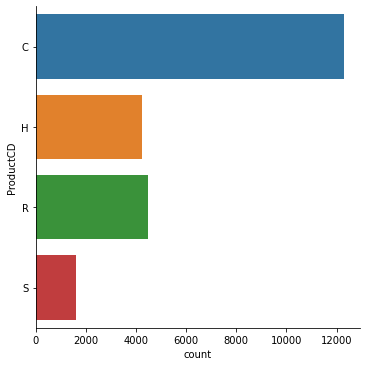

In [25]:
print(train_imputed['ProductCD'].value_counts(dropna=False))
sns.catplot(y='ProductCD',kind='count',data=train_imputed)
  

visa                13975
mastercard           7344
american express      923
discover              363
NaN                    31
Name: card4, dtype: int64


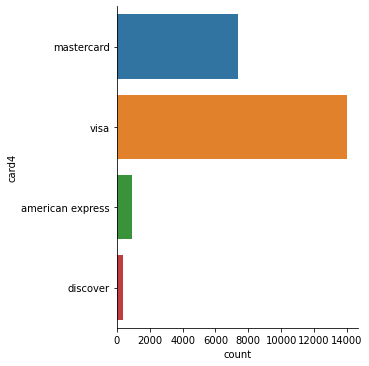

In [26]:
print(train_imputed['card4'].value_counts(dropna=False))
sns.catplot(y='card4',kind='count',data=train_imputed)

credit         12474
debit          10129
NaN               30
charge card        3
Name: card6, dtype: int64


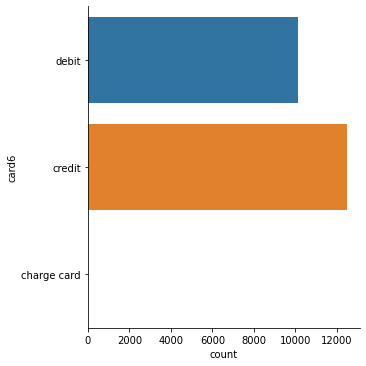

In [27]:
print(train_imputed['card6'].value_counts(dropna=False))
sns.catplot(y='card6',kind='count',data=train_imputed)

gmail.com           10375
hotmail.com          4044
anonymous.com        2043
NaN                  1996
yahoo.com            1451
outlook.com           593
aol.com               462
comcast.net           237
icloud.com            181
yahoo.com.mx          120
msn.com                97
live.com.mx            89
live.com               82
sbcglobal.net          79
verizon.net            77
outlook.es             75
me.com                 62
bellsouth.net          55
att.net                53
mail.com               51
hotmail.es             37
cox.net                36
ymail.com              35
hotmail.fr             29
protonmail.com         28
mac.com                23
optonline.net          22
web.de                 21
earthlink.net          20
charter.net            19
yahoo.fr               16
gmx.de                 14
gmail                  12
prodigy.net.mx          9
hotmail.co.uk           9
yahoo.de                8
roadrunner.com          7
embarqmail.com          7
suddenlink.n

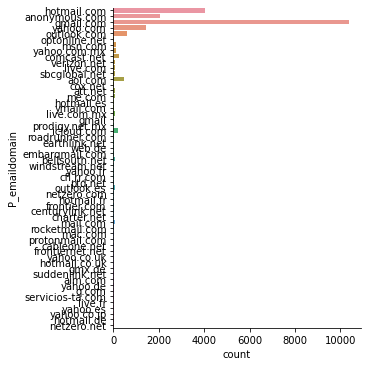

In [28]:
print(train_imputed['P_emaildomain'].value_counts(dropna=False))
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

gmail.com           10786
hotmail.com          3998
anonymous.com        2154
yahoo.com            1558
NaN                  1500
outlook.com           576
aol.com               451
icloud.com            292
comcast.net           174
yahoo.com.mx          120
live.com               96
live.com.mx            93
outlook.es             76
msn.com                71
verizon.net            63
me.com                 54
mail.com               54
sbcglobal.net          46
cox.net                42
protonmail.com         39
hotmail.es             37
att.net                34
bellsouth.net          29
hotmail.fr             29
ymail.com              22
optonline.net          21
mac.com                20
web.de                 20
yahoo.fr               16
rocketmail.com         15
gmx.de                 14
earthlink.net          13
charter.net            13
gmail                  12
hotmail.co.uk          10
prodigy.net.mx          9
yahoo.de                8
roadrunner.com          6
cfl.rr.com  

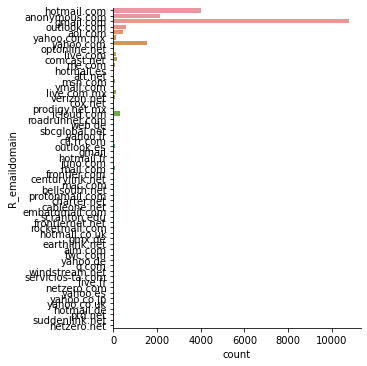

In [29]:
print(train_imputed['R_emaildomain'].value_counts(dropna=False))
sns.catplot(y='R_emaildomain',kind='count',data=train_imputed)

NotFound    19635
Found        3001
Name: id_12, dtype: int64


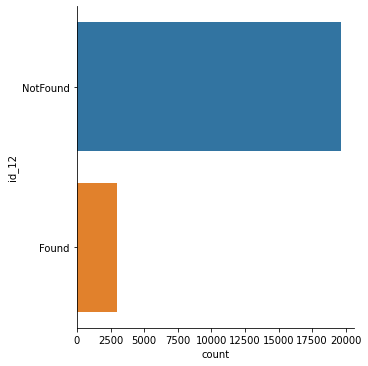

In [30]:
print(train_imputed['id_12'].value_counts(dropna=False))
sns.catplot(y='id_12',kind='count',data=train_imputed)

Found      12241
New         8067
Unknown     1967
NaN          361
Name: id_15, dtype: int64


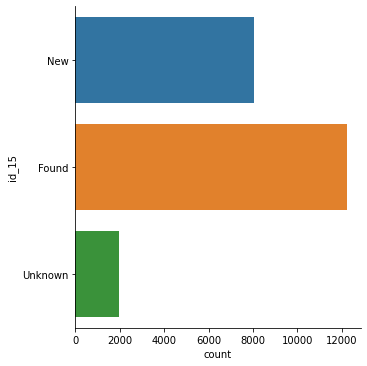

In [31]:
print(train_imputed['id_15'].value_counts(dropna=False))
sns.catplot(y='id_15',kind='count',data=train_imputed)

Found       12115
NotFound     8193
NaN          2328
Name: id_16, dtype: int64


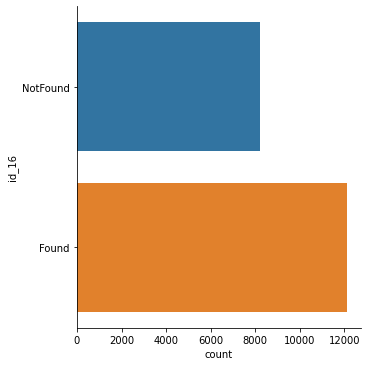

In [32]:
print(train_imputed['id_16'].value_counts(dropna=False))
sns.catplot(y='id_16',kind='count',data=train_imputed)

Found    13660
New       8611
NaN        365
Name: id_28, dtype: int64


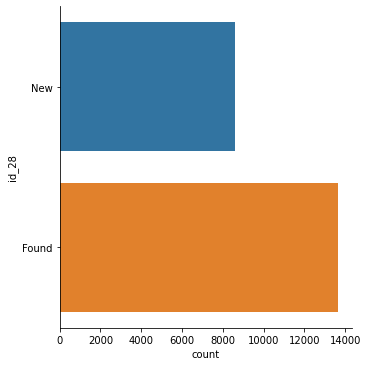

In [33]:
print(train_imputed['id_28'].value_counts(dropna=False))
sns.catplot(y='id_28',kind='count',data=train_imputed)

Found       13546
NotFound     8725
NaN           365
Name: id_29, dtype: int64


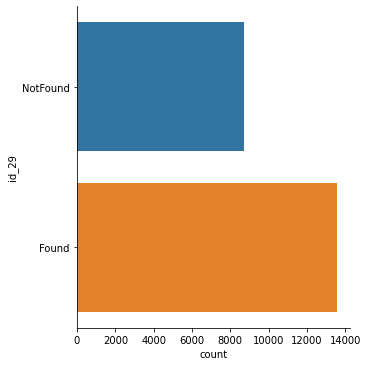

In [34]:
print(train_imputed['id_29'].value_counts(dropna=False))
sns.catplot(y='id_29',kind='count',data=train_imputed)

chrome 63.0                       3251
mobile safari generic             2039
mobile safari 11.0                1965
chrome 65.0                       1194
chrome generic                    1167
chrome 64.0                       1127
chrome 63.0 for android           1043
ie 11.0 for desktop                947
safari generic                     909
chrome 62.0                        886
chrome 64.0 for android            791
chrome 66.0                        717
chrome 65.0 for android            708
edge 16.0                          489
chrome 66.0 for android            484
NaN                                458
firefox 57.0                       451
mobile safari 10.0                 344
chrome 62.0 for android            315
chrome generic for android         204
firefox                            193
edge 15.0                          188
samsung browser 6.2                182
firefox 59.0                       166
firefox 58.0                       140
chrome 49.0              

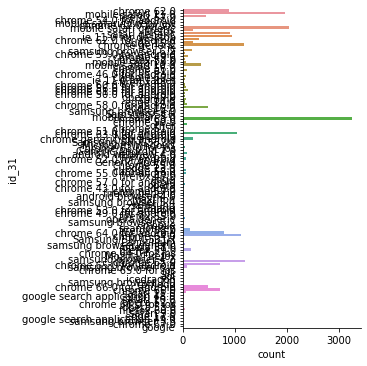

In [35]:
print(train_imputed['id_31'].value_counts(dropna=False))
sns.catplot(y='id_31',kind='count',data=train_imputed)

F      12479
T       9796
NaN      361
Name: id_35, dtype: int64


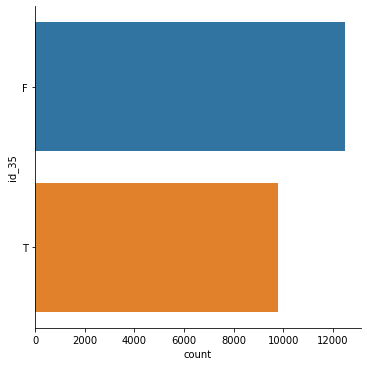

In [36]:
print(train_imputed['id_35'].value_counts(dropna=False))
sns.catplot(y='id_35',kind='count',data=train_imputed)

F      21437
T        838
NaN      361
Name: id_36, dtype: int64


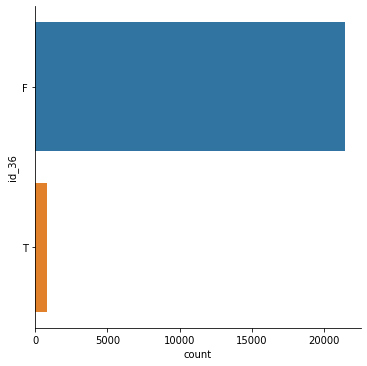

In [37]:
print(train_imputed['id_36'].value_counts(dropna=False))
sns.catplot(y='id_36',kind='count',data=train_imputed)

T      17793
F       4482
NaN      361
Name: id_37, dtype: int64


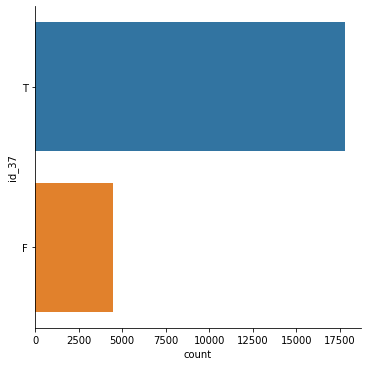

In [38]:
print(train_imputed['id_37'].value_counts(dropna=False))
sns.catplot(y='id_37',kind='count',data=train_imputed)

F      12883
T       9392
NaN      361
Name: id_38, dtype: int64


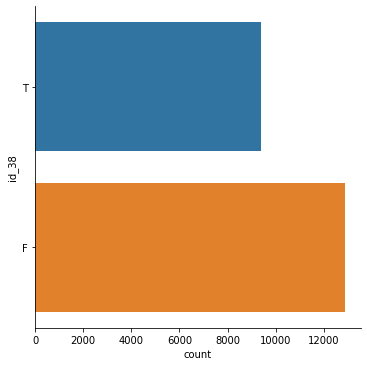

In [39]:
print(train_imputed['id_38'].value_counts(dropna=False))
sns.catplot(y='id_38',kind='count',data=train_imputed)

desktop    12394
mobile      9853
NaN          389
Name: DeviceType, dtype: int64


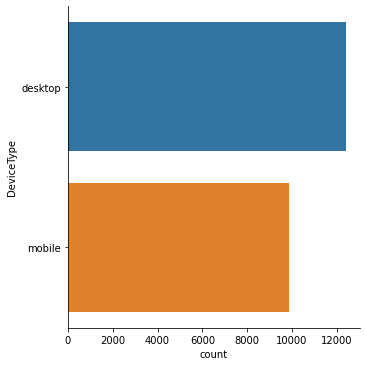

In [40]:
print(train_imputed['DeviceType'].value_counts(dropna=False))
sns.catplot(y='DeviceType',kind='count',data=train_imputed)

**Logistic Regression avec les features numerique**

In [57]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [58]:
train1=train_imputed.drop(['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37','id_38','DeviceType'],axis=1)
Y_train=train1['isFraud'].astype('int')
X_train=train1.drop('isFraud',axis=1)
scaler=preprocessing.StandardScaler()
X_train_st=scaler.fit_transform(X_train)


In [59]:
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.8386846231453335

**Feature importance**

Feature: TransactionID Score: 5.35386
Feature: TransactionDT Score: -4.96992
Feature: TransactionAmt Score: 0.47648
Feature: card1 Score: -0.10878
Feature: card2 Score: -0.13474
Feature: card3 Score: 0.30512
Feature: card5 Score: -0.01415
Feature: C1 Score: -2.68563
Feature: C2 Score: 2.56319
Feature: C3 Score: -0.64854
Feature: C4 Score: 1.55163
Feature: C5 Score: 0.00000
Feature: C6 Score: 0.49486
Feature: C7 Score: -4.58318
Feature: C8 Score: 3.79922
Feature: C9 Score: 0.00000
Feature: C10 Score: 3.86948
Feature: C11 Score: 5.50650
Feature: C12 Score: -1.10956
Feature: C13 Score: -3.21766
Feature: C14 Score: -6.29652
Feature: D1 Score: -0.23759
Feature: V95 Score: 0.27777
Feature: V96 Score: -0.24975
Feature: V97 Score: -0.13215
Feature: V98 Score: -0.03900
Feature: V99 Score: 0.61139
Feature: V100 Score: 0.07081
Feature: V101 Score: 0.32523
Feature: V102 Score: -0.12676
Feature: V103 Score: -0.12012
Feature: V104 Score: -0.25217
Feature: V105 Score: -1.43649
Feature: V106 Score: 0.

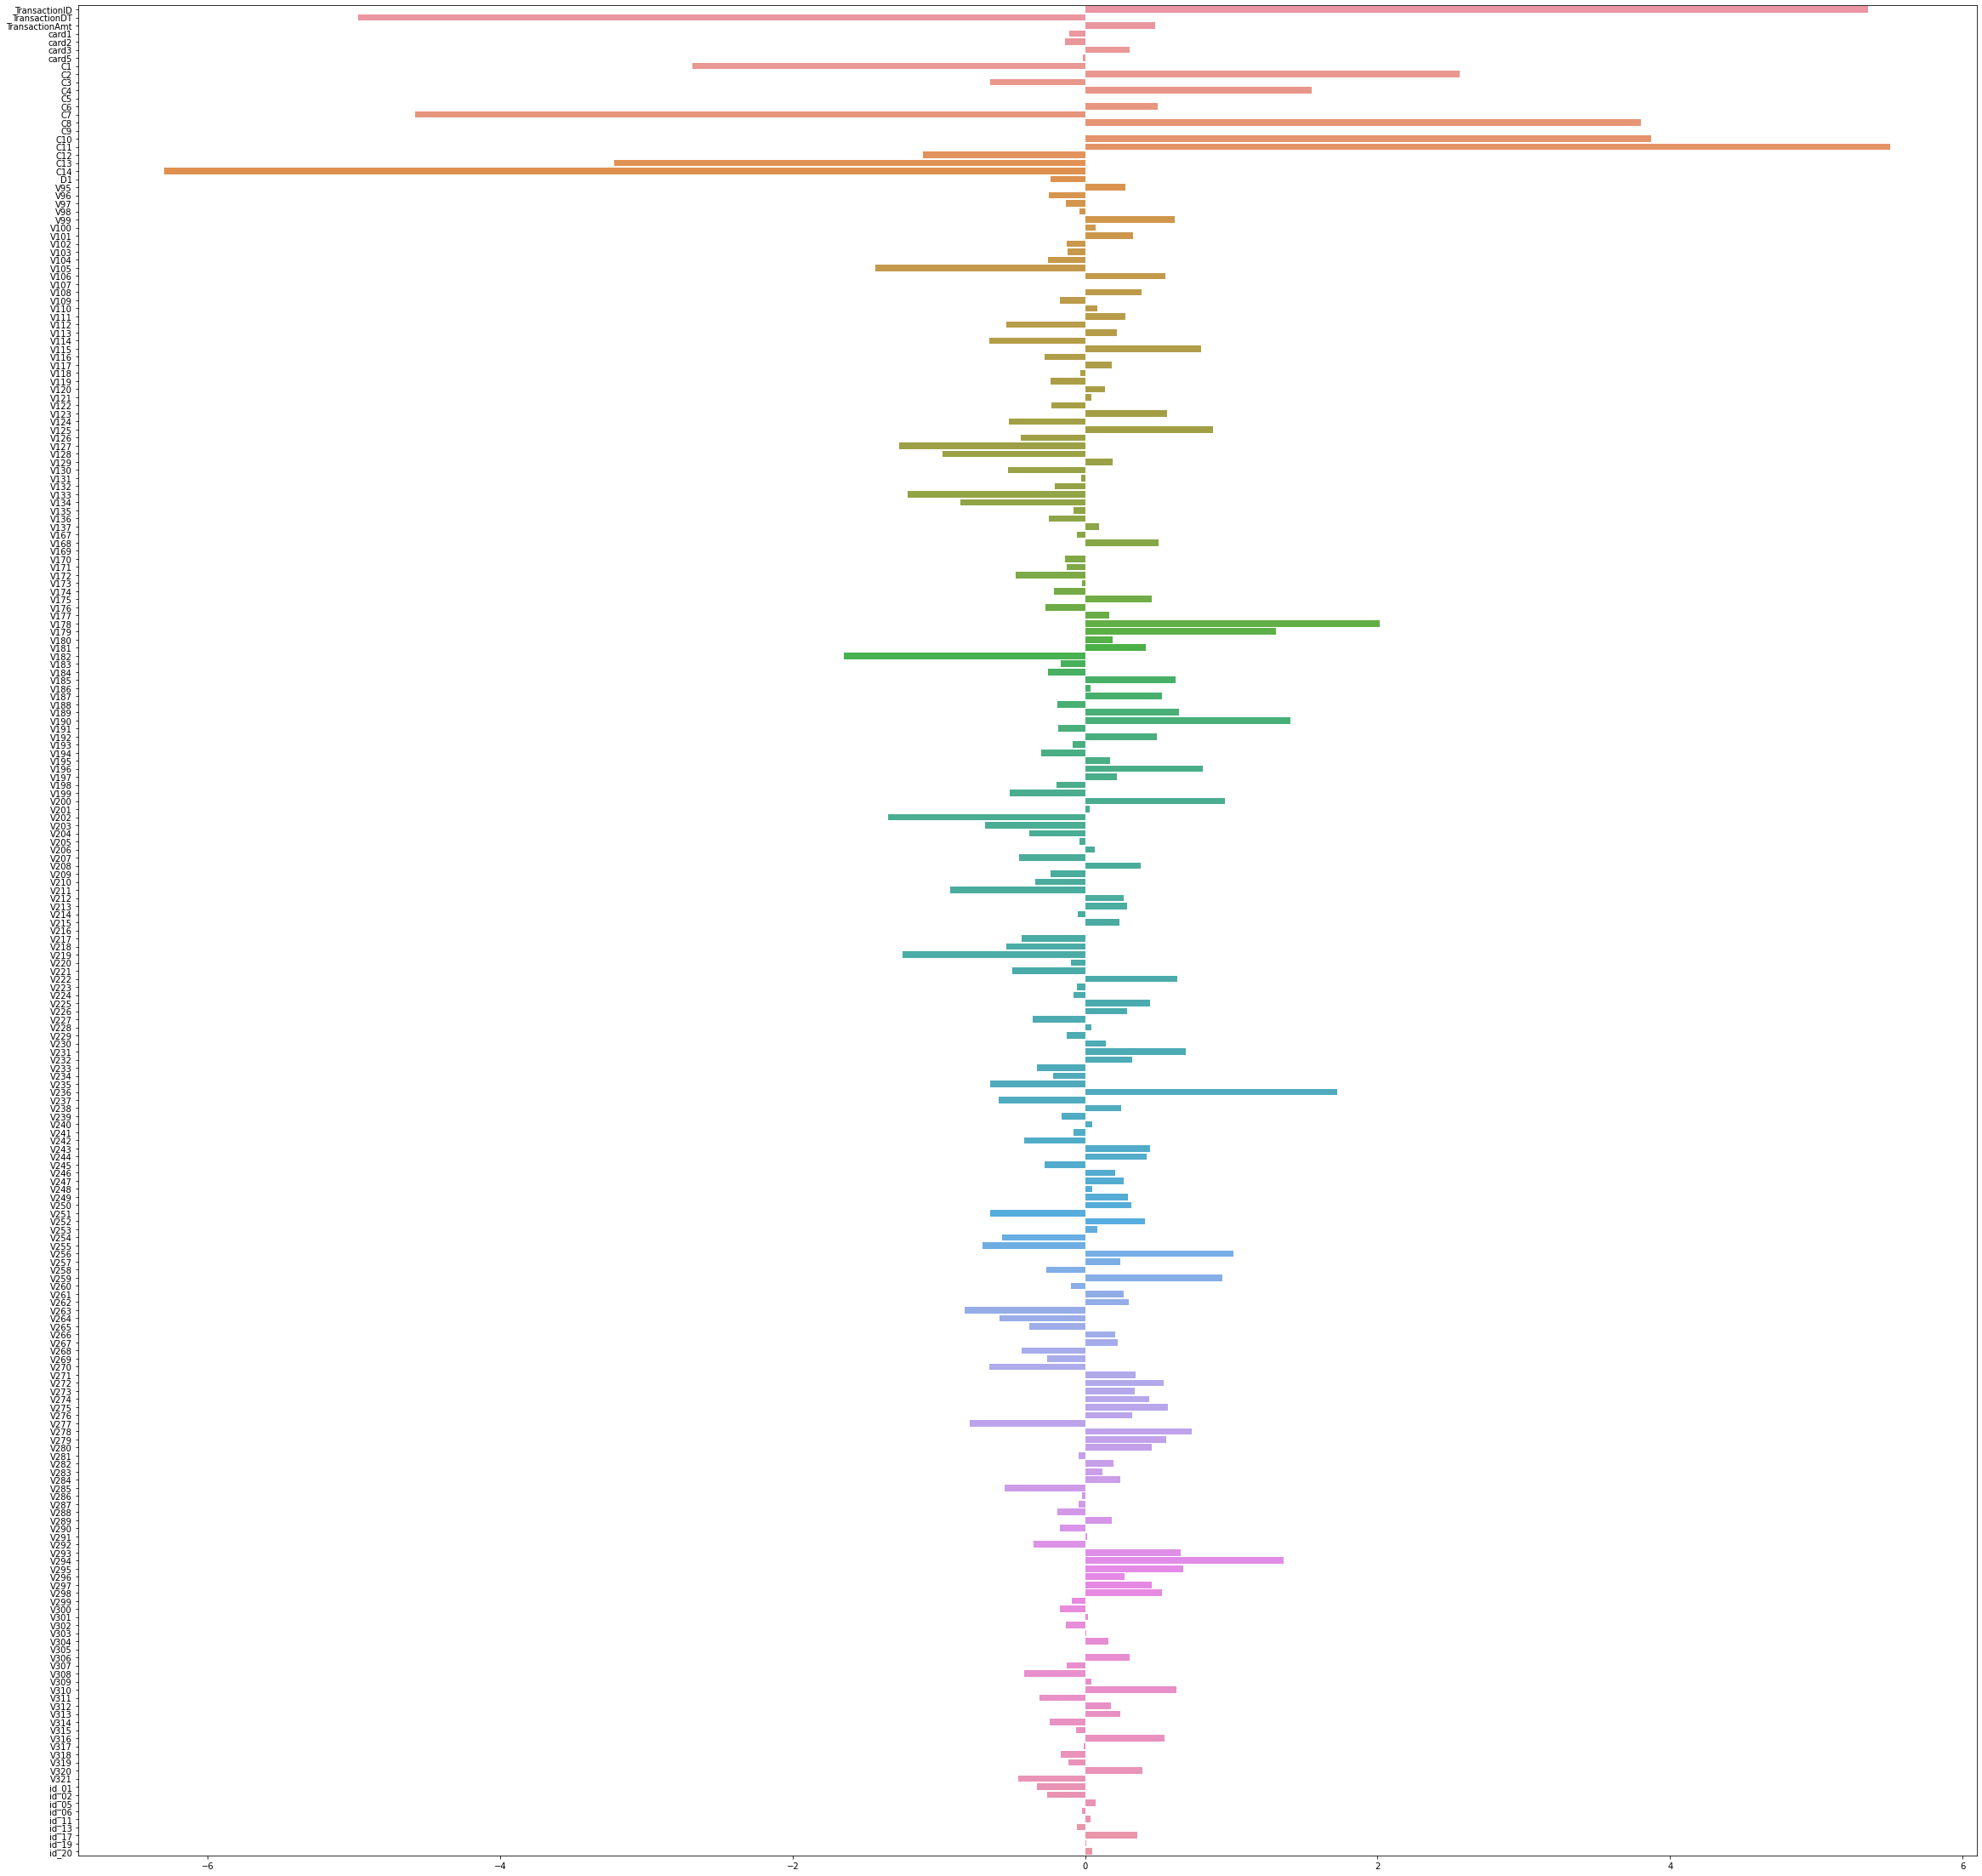

In [60]:
logit.fit(X_train_st,Y_train)
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',list(X_train.columns)[i],'Score: %.5f' % (v))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X_train.columns),ax=ax)

**Removing irrelevant features**

In [65]:
#il faut q'on fixe un thresh hold q
l1=[]#liste des features sans imporatnace
for i in range(len(imp)):
  if imp[i]==0:
    l1.append(list(X_train.columns)[i])
X_train1=X_train.drop(l1,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X_train1)
logit=LogisticRegression(C=1,random_state=42)
cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score reste le meme

0.8396634252569006

**Logistic Regression avec toutes les features(still unclear)**

In [68]:
sites = ['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37','id_38','DeviceType']
train1=train_imputed.drop(sites,axis=1)
Y_train=train1['isFraud'].astype('int')
X_train=train1.drop('isFraud',axis=1)
X1_train=pd.merge(X_train,pd.get_dummies(train_imputed[sites]),right_index=True,left_index=True)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X1_train)

In [69]:
logit=LogisticRegression(C=1,random_state=42)
cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.8359375484247096

**Feature importance**

Feature: TransactionID Score: 2.41009
Feature: TransactionDT Score: -1.99432
Feature: TransactionAmt Score: 0.65180
Feature: card1 Score: -0.08666
Feature: card2 Score: -0.17937
Feature: card3 Score: 0.30580
Feature: card5 Score: 0.00189
Feature: C1 Score: -2.42174
Feature: C2 Score: 2.54737
Feature: C3 Score: -0.72795
Feature: C4 Score: 0.82879
Feature: C5 Score: 0.00000
Feature: C6 Score: 0.69018
Feature: C7 Score: -3.18283
Feature: C8 Score: 2.51637
Feature: C9 Score: 0.00000
Feature: C10 Score: 2.26921
Feature: C11 Score: 3.84427
Feature: C12 Score: -0.42002
Feature: C13 Score: -2.46522
Feature: C14 Score: -4.24924
Feature: D1 Score: -0.25838
Feature: V95 Score: 0.18529
Feature: V96 Score: -0.02876
Feature: V97 Score: -0.02771
Feature: V98 Score: -0.02007
Feature: V99 Score: 0.63861
Feature: V100 Score: -0.20008
Feature: V101 Score: 0.18931
Feature: V102 Score: 0.02846
Feature: V103 Score: -0.01647
Feature: V104 Score: -0.33541
Feature: V105 Score: -0.83968
Feature: V106 Score: 0.1

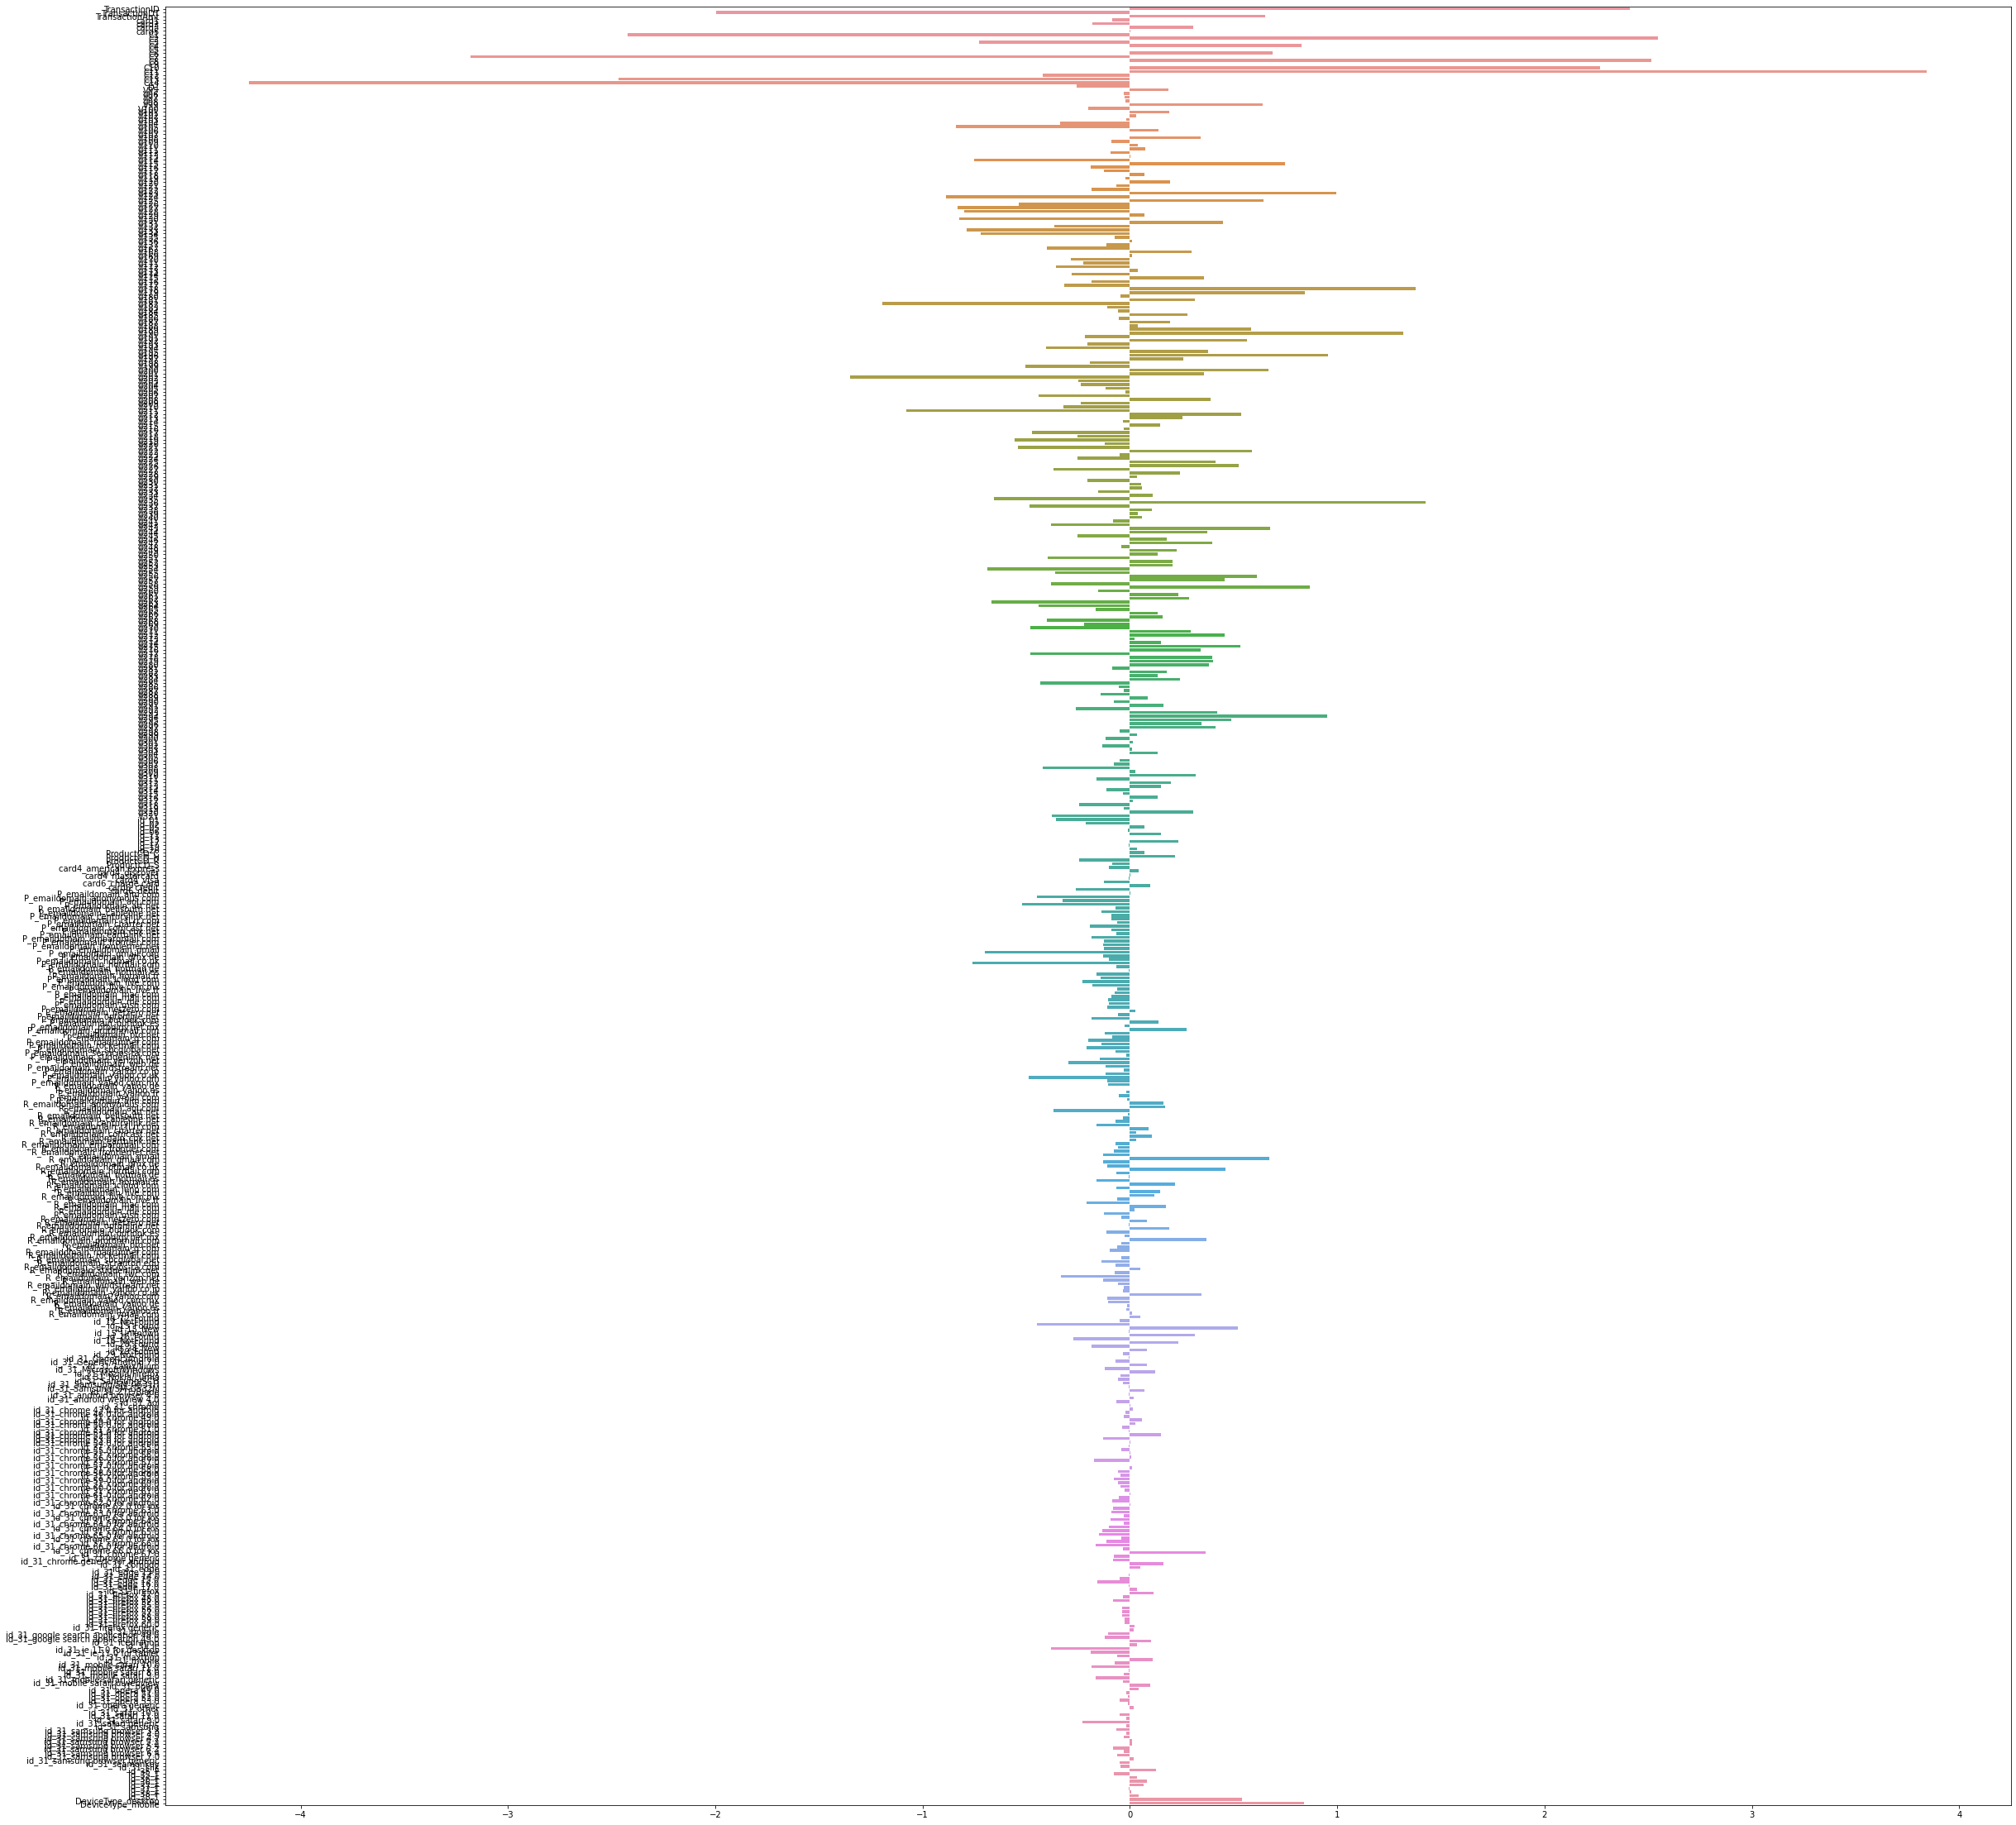

In [54]:
logit.fit(X_train_st1,Y_train)
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',list(X1_train.columns)[i],'Score: %.5f' % (v))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X1_train.columns),ax=ax)